__DQN vs DQN-ensemble on Catch__

Background: Deep ensemble learning was looked at in Osband et al. 2016 (https://arxiv.org/pdf/1602.04621.pdf). The main motivation behind learning several randomly initialized Q functions is to drive exploration. In general, each Q function could be defined by a unique set of parameters. However, it can be more efficient to share the lower levels of the network (convnet), and to have each Q function learn one extra unique linear layer on top of the shared representation (referenced as a "head"). Whereas Osband et al. 2016 propose a more general algorithm (see Appendix B, Algorithm 1), this presentation focusses on the sub-case where the agent acts based on the action with the maximum number of votes; where a single vote represents the action with the max q value for a single "head". 

__Implementation Details__:

_Domain_: 

The total screen size is 10x10, the agent has 3 actions [left, no-op, right] - controls a basket of three pixles and attempts to catch a falling fruit of a single pixle. The code can be found in "catch.py", it was taken from https://gist.github.com/EderSantana/c7222daa328f0e885093.

_Learning_:

No experience replay or target network is used. There are two main reasons for these reductions; the domain itself is fairly simple and clean (compared to atari), and to highlight the fact that learning an ensemble of randomly initialized Q functions can increase stability.

The agents each do Q learning updates on both their unique parameters (Q heads) and the shared ones, but the loss is normalized by the number of agents. This is similar to what Osband et al. 2016 did with their Atari experiments. 

Epsilon greedy exploration is used with epsilon = 0.1.

In [1]:
"""
    A really simple replay buffer class
"""

import numpy as np


class Replay(object):
    def __init__(self, max_size, state_shape):
        self.index = 0
        self.size = 0
        self.max_size = max_size
        self.state_shape = state_shape
        self.s = np.zeros([max_size] + state_shape, dtype='float32')
        self.a = np.zeros(max_size, dtype='int32')
        self.r = np.zeros(max_size, dtype='float32')
        self.s2 = np.zeros([max_size] + state_shape, dtype='float32')
        self.t = np.zeros(max_size, dtype='float32')
        
    def sample_batch(self, batch_size):
        indices = np.random.randint(low=0, high=self.size, size=batch_size)
        return self.s[indices], self.a[indices], self.r[indices], self.s2[indices], self.t[indices]
    
    def add_transition(self, s, a, r, s2, t):
        s = s.reshape(self.state_shape)
        s2 = s2.reshape(self.state_shape)
        self.s[self.index % self.max_size] = s
        self.a[self.index % self.max_size] = a
        self.r[self.index % self.max_size] = r
        self.s2[self.index % self.max_size] = s2
        self.t[self.index % self.max_size] = t
        self.index += 1
        self.size = min(self.index, self.max_size)

In [2]:
"""
    Neural network based agent - requires Keras and Theano. 
    Note: is not compatible with tensorflow due to the differing dimensions
          - be sure to set the keras backend to 'theano' and the dim-ordering to 'th'
"""
from keras import backend as K
from keras.layers import Input, merge
from keras.layers.core import Dense, Flatten, Reshape
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.optimizers import RMSprop


def build_network(state_shape, nb_actions, nb_agents):
    # shared layers
    input_dim = tuple(state_shape)
    states = Input(shape=input_dim, dtype='float32', name='states')
    shared_conv = Convolution2D(nb_filter=16,
                                nb_row=3,
                                nb_col=3,
                                border_mode='same',
                                subsample=(1, 1),
                                activation='relu',
                                init='he_uniform')(states)
    flatten = Flatten()(shared_conv)
    shared_dense = Dense(output_dim=128, init='he_uniform', activation='relu')(flatten)
    
    # unique q-heads
    q_heads = [Dense(output_dim=nb_actions, init='he_uniform', activation='linear')(shared_dense)
               for i in range(nb_agents)]
    
    # merge q-heads and reshape
    merged = merge(q_heads, mode='concat') if nb_agents > 1 else q_heads[0]
    out = Reshape((nb_agents, nb_actions))(merged)
    
    return Model(input=states, output=out)


class Agent(object):
    def __init__(self, state_shape, nb_actions, nb_agents, gamma=0.99, lr=0.001, batch_size=32):
        self.state_shape = state_shape
        self.nb_actions = nb_actions
        self.nb_agents = nb_agents
        self.gamma = gamma
        self.lr = lr
        self.batch_size = 32
        self.replay = Replay(max_size=10000, state_shape=state_shape)
        self.network = build_network(state_shape, nb_actions, nb_agents)
        self._compile(state_shape, nb_actions, nb_agents)

    def _compile(self, state_shape, nb_actions, nb_agents):
        # Inputs
        s = K.placeholder(shape=tuple([None] + state_shape))
        a = K.placeholder(ndim=1, dtype='int32')
        r = K.placeholder(ndim=2, dtype='float32')
        s2 = K.placeholder(shape=tuple([None] + state_shape))
        t = K.placeholder(ndim=2, dtype='float32')

        # Q(s, a) for each agent
        q = self.network(s) # q has shape (batch_size, nb_agents, nb_actions)
        preds = q[K.T.arange(s.shape[0]), :, a]
        
        # One hot vector representing the max Q(s, a) for each agent: 
        # eg. Q(s) = (0.5, 0.25, 0.1) -> (1, 0, 0)
        votes = K.sum(K.eye(self.nb_actions, dtype='float32')[K.argmax(q[0], axis=1)], axis=0)

        # r + (1 - t) * gamma * max_a(Q'(s')) for each agent
        q2 = self.network(s2)
        q2_max = K.max(q2, axis=2)
        targets = r + (K.cast_to_floatx(1) - t) * self.gamma * q2_max

        # Loss and Updates
        cost = K.sum(0.5 * (targets - preds) ** 2) 
        optimizer = RMSprop(lr=self.lr, rho=.95, epsilon=1e-7)
        updates = optimizer.get_updates(params=self.network.trainable_weights, loss=cost, constraints={})

        # Compiled Functions
        self._train = K.function(inputs=[s, a, r, s2, t], outputs=[cost], updates=updates)
        self._predict = K.function(inputs=[s], outputs=votes)

    def get_action(self, state, epsilon):
        state = np.expand_dims(state.reshape(self.state_shape), axis=0)
        if np.random.binomial(1, epsilon):
            return np.random.randint(self.nb_actions)
        else:
            votes = self._predict([state])
            return np.argmax(votes)
        
    def learn(self):
        s, a, r, s2, t = self.replay.sample_batch(self.batch_size)
        r = np.expand_dims(r, axis=1)
        t = np.expand_dims(t, axis=1)
        r = np.tile(r, reps=(1, self.nb_agents))
        t = np.tile(t, reps=(1, self.nb_agents))
        return self._train([s, a, r, s2, t])

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GPU (CNMeM is disabled, cuDNN 5110)


In [3]:
"""
    Global imports and variables
"""

%matplotlib inline

import numpy as np
import seaborn
import pickle
import numpy as np

from catch import Catch

nb_runs_each = 3
nb_episodes = 100
nb_heads_list = [1, 2, 5, 10]
min_replay_size = 100

In [4]:
"""
    Runs each agent defined by the number of heads it uses ("nb_heads_list") -
    for a fixed number of episodes ("nb_episodes"). 
    Each run is repeated "nb_runs_each" times to compute some measure of variance.
"""

env = Catch()
agents = [Agent(env.state_shape, env.nb_actions, nb_heads) for nb_heads in nb_heads_list]
all_agent_rewards = np.empty((nb_runs_each, nb_episodes, len(nb_heads_list)))

for agent_index, agent in enumerate(agents):
    for run in range(nb_runs_each):
        rewards = 0
        for ep in range(nb_episodes):
            env.reset()
            terminal = False
            while not terminal:
                s = env.observe()
                a = agent.get_action(s, epsilon=0.1)
                s2, r, terminal = env.act(a)
                agent.replay.add_transition(s, a, r, s2, terminal)
                if agent.replay.size > min_replay_size:
                    agent.learn()
                rewards += r
            all_agent_rewards[run, ep, agent_index] = rewards
            
with open('rewards', 'wb') as f:
    pickle.dump(all_agent_rewards, f)

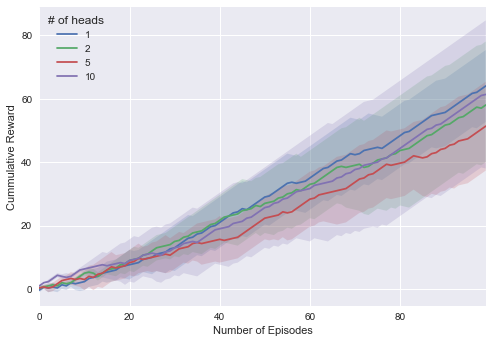

In [5]:
with open('rewards', 'rb') as f:
     all_agent_rewards = pickle.load(f)

plot = seaborn.tsplot(data=all_agent_rewards, legend=True, condition=nb_heads_list)
plot.legend(loc='upper left', title='# of heads')
plot.set_ylabel("Cummulative Reward")
plot.set_xlabel("Number of Episodes")